## Tesco Clubcard Data Preparation & Analysis

This project revolves around a **synthetic dataset** created using Tesco Clubcard Data, which can be obtained by clubcard users from Tesco (UK supermarket). Once requested, Tesco provides the data is **JSON** format. To ensure **privacy**, the dataset has undergone **resampling** to ensure the anonymity of individual shopping habits.

If you wish to apply this notebook to your **personal data**, just tweak the code that reads the JSON file to match your file's location. The notebook generates two **CSV output files** ready for integration into popular data visualization tools like **Tableau** or **Power BI**, enabling you to expand your analysis.

This project serves as a compelling example of data's capacity to unveil **intriguing trends**. It dives into identifying price shifts, spotlighting popular purchases, and even quantifying genuine savings from **clubcard usage**. Stay tuned for more **Medium articles** that delve into specific aspects of this project.

### 1. Data Acquisition and Preparation

#### 1.1 Importing necessary libraries

In [1]:
# import libraries

import json
import pandas as pd
from pprint import pprint
from pandas import json_normalize
import plotly.express as px
import plotly.subplots
import plotly.graph_objs as go

#### 1.2 Reading data from JSON

The JSON file contain multiple layers with personal information such as email address, name, address, purchase history, etc. For this exercise we are onyl interested in the **purchase** layer. The other data in the JSON is ignored as it is not relevant for analysis and it is personal data (or PII - Personally Idetifiable Information).

In [2]:
# reading the JSON file
with open('data/in/Tesco-Customer-Data.json', 'r') as f:
    tesco_clubcard_data = json.load(f)

# Isolating the 'purchase' layer
purchase_data = tesco_clubcard_data.get('Purchase', {})

# Now, 'purchase_data' contains only the information from the 'purchase' layer


#### 1.3 Basic inspection of data structure

Below we have an example of a purchase that contains 2 products. In this notebook, terms like purchase or basket are used interchangeably.

In [3]:
pprint(purchase_data[0][0])

{'basketValueGross': '5.4',
 'basketValueNet': '5.4',
 'overallBasketSavings': 'NA',
 'paymentType': [{'amount': '5.4', 'category': 'NA', 'type': 'VisaDebit'}],
 'product': [{'channel': 'IN_STORE',
              'name': 'Tesco Tiramisu 2X85g',
              'price': '2.25',
              'quantity': '1',
              'volumeInLitres': 'NA',
              'weightInGrams': 'NA'},
             {'channel': 'IN_STORE',
              'name': 'Belvita Biscuit Strawberry & Yogurt Crunch 253G',
              'price': '3.15',
              'quantity': '1',
              'volumeInLitres': 'NA',
              'weightInGrams': 'NA'}],
 'purchaseType': 'IN_STORE',
 'says': 'NA',
 'storeAddress': 'Store Address [Redacted]',
 'storeFormat': 'Express',
 'storeId': '5989',
 'storeName': 'Store Name [Redacted]',
 'timeStamp': '2023-08-08 21:01:43.656'}


#### 1.4 Transforming JSON data into dataframes

We are creating 2 different dataframes. One will contain information on purchases (one specific shop at a point in time) and another dataframe will contain the list of products bought. A basket_id for each purchase is created and referenced in the products dataframe to connect product to a purchase.

In [4]:
# Flattening the list of lists to a single list of dictionaries
flattened_purchase_data = [item for sublist in purchase_data for item in sublist]

# Initialize empty DataFrames for purchases and products
purchase_df = pd.DataFrame()
product_df = pd.DataFrame()

In [5]:
# Generate basket IDs
basket_id = 0

# Loop through the flattened list of dictionaries to create the basket_id
for p in flattened_purchase_data:
    # Increment basket ID
    basket_id += 1
    
    # Extract common basket-level information
    base_data = {k: v for k, v in p.items() if k not in ['paymentType', 'product']}
    
    # Generate a unique basket ID and add it to base_data
    base_data['basket_id'] = f'B{basket_id}'
    
    # Add this dictionary to the purchase DataFrame
    purchase_df = purchase_df.append(base_data, ignore_index=True)
    
    # Flatten 'product' and add 'basket_id' column
    product_data = json_normalize(p['product'], sep='_')
    product_data['basket_id'] = f'B{basket_id}'
    
    # Add this DataFrame to the product DataFrame
    product_df = pd.concat([product_df, product_data], ignore_index=True)

### 2. Data Cleaning and Transformation

#### 2.1 Dropping columns that won't be included in the analysis

Drop columns that won't be included in the analyis. If you wish to share your results with a wider audience, think about dropping theseolumns as they could potentially reveal the area you live in.

In [6]:
# Drop 'storeName' and 'storeAddress' columns  
purchase_df.drop(['storeName', 'storeAddress'], axis=1, inplace=True)

Now, **purchase_df** contains purchase-level data with unique basket IDs.**product_df** contains product-level data, also with basket IDs for joining later.

In [7]:
product_df.head(5)

,name,quantity,channel,weightInGrams,price,volumeInLitres,basket_id
0,Tesco Tiramisu 2X85g,1,IN_STORE,NA,2.25,NA,B1
1,Belvita Biscuit Strawberry & Yogurt Crunch 253G,1,IN_STORE,NA,3.15,NA,B1
2,Tesco 6 Mini Garlic & Coriander Naans,1,IN_STORE,NA,1.75,NA,B2
3,Tesco Sweet Vine Ripened Tomatoes 255G,1,IN_STORE,NA,1.3,NA,B2
4,Tesco Effervescent Vitamin C Plus Zinc X 20,1,IN_STORE,NA,1.95,NA,B3


In [8]:
purchase_df.head(5)

,basketValueGross,basketValueNet,basket_id,overallBasketSavings,purchaseType,says,storeFormat,storeId,timeStamp
0,5.4,5.4,B1,NA,IN_STORE,NA,Express,5989,2023-08-08 21:01:43.656
1,3.05,3.05,B2,NA,IN_STORE,NA,Express,5989,2023-08-08 12:44:03.307
2,1.95,1.95,B3,NA,IN_STORE,NA,Express,5989,2023-08-06 20:37:32.734
3,2.4,2.4,B4,NA,IN_STORE,NA,Express,5989,2023-08-06 14:46:45.044
4,2.41,2.41,B5,NA,IN_STORE,NA,Metro,2239,2023-08-05 16:02:24.524


#### 2.2 Creating new relevant columns

##### 2.2.1 Assign a product_id to each product in product_df

If the same product has been bought multiple time, the product_id will be the same ecah time a product has been purchased. 

In [9]:
# Create a mapping of product names to IDs. This assumes that you've standardized your product names as mentioned above.
unique_product_names = product_df['name'].unique()
product_id_map = {name: f"P{i+1}" for i, name in enumerate(unique_product_names)}

# Map the product names to IDs and create a new column
product_df['product_id'] = product_df['name'].map(product_id_map)

In [10]:
product_df.head(5)

,name,quantity,channel,weightInGrams,price,volumeInLitres,basket_id,product_id
0,Tesco Tiramisu 2X85g,1,IN_STORE,NA,2.25,NA,B1,P1
1,Belvita Biscuit Strawberry & Yogurt Crunch 253G,1,IN_STORE,NA,3.15,NA,B1,P2
2,Tesco 6 Mini Garlic & Coriander Naans,1,IN_STORE,NA,1.75,NA,B2,P3
3,Tesco Sweet Vine Ripened Tomatoes 255G,1,IN_STORE,NA,1.3,NA,B2,P4
4,Tesco Effervescent Vitamin C Plus Zinc X 20,1,IN_STORE,NA,1.95,NA,B3,P5


##### 2.2.2 Creating Additional Timestamp Columns for Analysis

Creating multiple columns from a timestamp allows us to extract specific elements like year, month, day, hour, and minute. This facilitates easier data analysis and visualization, enabling us to uncover temporal patterns and trends within our dataset.

In [11]:
import pandas as pd

# Convert the 'timeStamp' column to datetime format
purchase_df['timeStamp'] = pd.to_datetime(purchase_df['timeStamp'])

# Extracting the various components
purchase_df['year'] = purchase_df['timeStamp'].dt.year
purchase_df['month'] = purchase_df['timeStamp'].dt.month
purchase_df['day'] = purchase_df['timeStamp'].dt.day
purchase_df['date'] = purchase_df['timeStamp'].dt.date
purchase_df['time'] = purchase_df['timeStamp'].dt.strftime('%H:%M:%S')


In [12]:
purchase_df.head(5)

,basketValueGross,basketValueNet,basket_id,overallBasketSavings,purchaseType,says,storeFormat,storeId,timeStamp,year,month,day,date,time
0,5.4,5.4,B1,NA,IN_STORE,NA,Express,5989,2023-08-08 21:01:43.656,2023,8,8,2023-08-08,21:01:43
1,3.05,3.05,B2,NA,IN_STORE,NA,Express,5989,2023-08-08 12:44:03.307,2023,8,8,2023-08-08,12:44:03
2,1.95,1.95,B3,NA,IN_STORE,NA,Express,5989,2023-08-06 20:37:32.734,2023,8,6,2023-08-06,20:37:32
3,2.4,2.4,B4,NA,IN_STORE,NA,Express,5989,2023-08-06 14:46:45.044,2023,8,6,2023-08-06,14:46:45
4,2.41,2.41,B5,NA,IN_STORE,NA,Metro,2239,2023-08-05 16:02:24.524,2023,8,5,2023-08-05,16:02:24


#### 2.3. Handling missing data (NaNs or NAs)

There are four columns that seem to have lots of NA values. By having  quick look at the unique values in each of these columns, we can see that **weightInGrams**, **volumeInLitres** and **says** won't add any value to our analysis. Therefore, we will be dropping these columns.

In [13]:
# For product_df
print("Unique values in 'weightInGrams':", product_df['weightInGrams'].unique())
print("Unique values in 'volumeInLitres':", product_df['volumeInLitres'].unique())

# For purchase_df
print("Unique values in 'says':", purchase_df['says'].unique())
print("Unique values in 'overallBasketSavings':", purchase_df['overallBasketSavings'].unique())


Unique values in 'weightInGrams': ['NA']
Unique values in 'volumeInLitres': ['NA']
Unique values in 'says': ['NA']
Unique values in 'overallBasketSavings': ['NA' '1.55' '1.1' '1.5' '1.0' '0.71' '2.05' '0.8' '3.05' '2.75' '1.25'
 '0.95' '1.6' '0.6' '1.65' '1.45' '0.7' '0.55' '1.4' '0.9' '2.2' '0.4'
 '0.3' '0.5' '2.7' '2.8' '0.75' '0.1' '1.3' '4.1' '3.3' '0.15' '1.75'
 '0.25' '0.65' '3.0' '2.25' '3.2' '1.15' '2.5']


In [14]:
# Dropping columns from product_df
product_df.drop(['weightInGrams', 'volumeInLitres'], axis=1, inplace=True)

# Dropping the column from purchase_df
purchase_df.drop(['says'], axis=1, inplace=True)


In [15]:
product_df.head(5)

,name,quantity,channel,price,basket_id,product_id
0,Tesco Tiramisu 2X85g,1,IN_STORE,2.25,B1,P1
1,Belvita Biscuit Strawberry & Yogurt Crunch 253G,1,IN_STORE,3.15,B1,P2
2,Tesco 6 Mini Garlic & Coriander Naans,1,IN_STORE,1.75,B2,P3
3,Tesco Sweet Vine Ripened Tomatoes 255G,1,IN_STORE,1.3,B2,P4
4,Tesco Effervescent Vitamin C Plus Zinc X 20,1,IN_STORE,1.95,B3,P5


In [16]:
purchase_df.head(5)

,basketValueGross,basketValueNet,basket_id,overallBasketSavings,purchaseType,storeFormat,storeId,timeStamp,year,month,day,date,time
0,5.4,5.4,B1,NA,IN_STORE,Express,5989,2023-08-08 21:01:43.656,2023,8,8,2023-08-08,21:01:43
1,3.05,3.05,B2,NA,IN_STORE,Express,5989,2023-08-08 12:44:03.307,2023,8,8,2023-08-08,12:44:03
2,1.95,1.95,B3,NA,IN_STORE,Express,5989,2023-08-06 20:37:32.734,2023,8,6,2023-08-06,20:37:32
3,2.4,2.4,B4,NA,IN_STORE,Express,5989,2023-08-06 14:46:45.044,2023,8,6,2023-08-06,14:46:45
4,2.41,2.41,B5,NA,IN_STORE,Metro,2239,2023-08-05 16:02:24.524,2023,8,5,2023-08-05,16:02:24


Now, our dataframes look a bit tidier.

#### 2.4 Ensuring Correct Data Types

In [17]:
product_df.dtypes

name          object
quantity      object
channel       object
price         object
basket_id     object
product_id    object
dtype: object

After reading the data from JSON format, you may notice that many of the data types are initially classified as **object**. This is often due to JSON's flexibility in representing different data types. However, it's beneficial to convert these object types to their appropriate numeric or categorical formats. Numeric data, such as prices and quantities, can be converted to float or integer types for more accurate analysis.

The **basket_id** and **product_id** columns have been kept as object data types, as these identifiers consist of alphanumeric values and are used for tracking and referencing purposes, making them well-suited for object type storage.

In [18]:
product_df['quantity'] = pd.to_numeric(product_df['quantity'], errors='coerce')
product_df['price'] = pd.to_numeric(product_df['price'], errors='coerce')
product_df['name'] = product_df['name'].astype('string')

In [19]:
product_df.dtypes

name           string
quantity        int64
channel        object
price         float64
basket_id      object
product_id     object
dtype: object

Let's have a look at our other dataframe now.

In [20]:
purchase_df.dtypes

basketValueGross                object
basketValueNet                  object
basket_id                       object
overallBasketSavings            object
purchaseType                    object
storeFormat                     object
storeId                         object
timeStamp               datetime64[ns]
year                             int64
month                            int64
day                              int64
date                            object
time                            object
dtype: object

In [21]:
# Convert to float
purchase_df['basketValueGross'] = pd.to_numeric(purchase_df['basketValueGross'], errors='coerce')
purchase_df['basketValueNet'] = pd.to_numeric(purchase_df['basketValueNet'], errors='coerce')
purchase_df['overallBasketSavings'] = pd.to_numeric(purchase_df['overallBasketSavings'], errors='coerce')

#Convert the 'date' column to a datetime data type to enable date-based calculations and sorting
purchase_df['date'] = pd.to_datetime(purchase_df['date'])

# Convert the 'time' column to a timedelta data type to enable time-based calculations and sorting
purchase_df['time'] = pd.to_timedelta(purchase_df['time'])


Your other columns like **storeId**, **purchaseType**, and **storeFormat** are already in the object (string) format.This is appropriate as we are treating these columns as categorical variables in our analysis.

In [22]:
purchase_df.dtypes

basketValueGross                float64
basketValueNet                  float64
basket_id                        object
overallBasketSavings            float64
purchaseType                     object
storeFormat                      object
storeId                          object
timeStamp                datetime64[ns]
year                              int64
month                             int64
day                               int64
date                     datetime64[ns]
time                    timedelta64[ns]
dtype: object

#### 2.5 Calculate Missing Data Percentage

In [23]:
# Calculate the percentage of missing values for each column in purchase_df
missing_percentage_purchase = purchase_df.isnull().mean() * 100
missing_percentage_product = product_df.isnull().mean() * 100

In [24]:
missing_percentage_purchase

basketValueGross         0.000000
basketValueNet           0.000000
basket_id                0.000000
overallBasketSavings    65.436242
purchaseType             0.000000
storeFormat              0.000000
storeId                  0.000000
timeStamp                0.000000
year                     0.000000
month                    0.000000
day                      0.000000
date                     0.000000
time                     0.000000
dtype: float64

In [25]:
missing_percentage_product

name          0.0
quantity      0.0
channel       0.0
price         0.0
basket_id     0.0
product_id    0.0
dtype: float64

In the **overallBasketSavings** column, about 66.1% of values are missing. This is expected, as not every basket will have discounted items, thus resulting in no overall savings. The missing values reflect the reality of retail transactions and should be considered when conducting any analysis involving this field.

### 3. Data Exploration - Summary Statistics

In [26]:
summary_stats = product_df.describe()
print(summary_stats)

         quantity       price
count  907.000000  907.000000
mean     1.176406    1.617299
std      0.764683    1.127149
min      1.000000    0.010000
25%      1.000000    0.820000
50%      1.000000    1.400000
75%      1.000000    2.075000
max     15.000000    7.750000


In [27]:
summary_stats = purchase_df.describe()
print(summary_stats)

       basketValueGross  basketValueNet  overallBasketSavings         year  \
count        298.000000      298.000000            103.000000   298.000000   
mean           5.335973        5.191174              1.276796  2022.406040   
std            3.822695        3.753067              0.802188     0.525027   
min            0.200000        0.200000              0.100000  2021.000000   
25%            2.850000        2.612500              0.705000  2022.000000   
50%            4.275000        4.125000              1.000000  2022.000000   
75%            6.737500        6.625000              1.500000  2023.000000   
max           28.250000       28.250000              4.100000  2023.000000   

            month         day                    time  
count  298.000000  298.000000                     298  
mean     6.067114   15.691275  0 days 17:11:35.895973  
std      2.879545    8.745484  0 days 03:08:07.749709  
min      1.000000    1.000000         0 days 08:40:18  
25%      4.000000

### 4. Data Analysis

#### 4.1. KPIs Visualisation

In our analysis, we encounter terms like **gross** and **net** values. The term **gross** represents the total amount before any deductions or adjustments, while **net** refers to the amount remaining after deductions have been taken into account. For instance, **basketValueGross** indicates the initial total cost of a shopping basket, and **basketValueNet** represents the final amount after factoring in any discounts or savings.

In [28]:
# Calculate KPIs
total_money_spent = purchase_df['basketValueNet'].sum()
total_savings = purchase_df['overallBasketSavings'].sum()
average_basket_value = purchase_df.groupby('basket_id')['basketValueNet'].sum().mean()

In [52]:
# Create subplots with 1 row and 3 columns
fig = plotly.subplots.make_subplots(rows=1, cols=3)

# Add KPIs as text annotations
kpi_annotations = [
    dict(
        text=f"£{total_money_spent:.2f}",
        font=dict(size=30, color='blue'),
        showarrow=False
    ),
    dict(
        text=f"£{total_savings:.2f}",
        font=dict(size=30, color='green'),
        showarrow=False,
        xanchor="center",
        yanchor="middle"
    ),
    dict(
        text=f"£{average_basket_value:.2f}",
        font=dict(size=30, color='purple'),
        showarrow=False
    )
]

# Add titles to each KPI
kpi_titles = ["Total Money Spent", "Total Savings", "Average Basket Value"]

# Add KPIs as annotations to subplots
for i in range(3):
    fig.add_annotation(
        kpi_annotations[i],
        xref=f"x{i+1}",
        yref="paper",
        xanchor="center",
        yanchor="middle",
    )
    fig.update_xaxes(title_text=kpi_titles[i], row=1, col=i+1, showticklabels=False, showline=True, showgrid=False, zeroline=False,)
    fig.update_yaxes(showticklabels=False, showline=True, showgrid=False,zeroline=False)
    
# Update layout
fig.update_layout(
    title="Key Performance Indicators (KPIs)",
    height=200,
    margin=dict(t=50, b=0),
    showlegend=False
)
# Show the plot
fig.show()


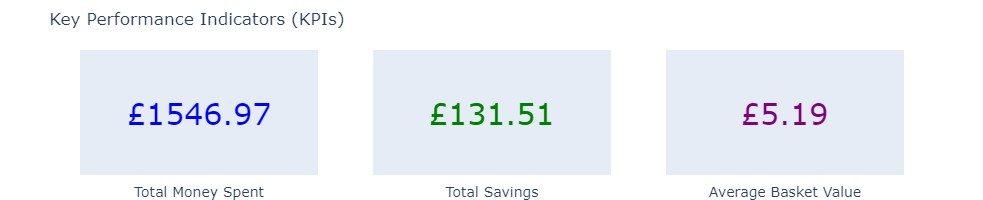

#### 4.2. Most Frequently Purchased Products

In [50]:
# Count the frequency of each product and sort them in descending order
most_frequent_products = product_df['name'].value_counts().reset_index()
most_frequent_products.columns = ['Product Name', 'Frequency']
print(most_frequent_products.head())

                                 Product Name  Frequency
0       Tesco Stonebaked Pepperoni Pizza 277G         38
1                        Tesco Tiramisu 2X85g         38
2                             Banana Each (C)         36
3                  Lipton Ice Tea Peach 500Ml         27
4  Alpro Soya No Sugars Chilled Drink 1 Litre         25


Now let's plot the top 10 most purchased products using the plotly library.

In [36]:
# Top 10 Most Frequently Purchased Products
top_10_products = product_df['name'].value_counts().iloc[:10].reset_index()
top_10_products.columns = ['Product Name', 'No. of Purchases']
fig1 = px.bar(top_10_products, x='Product Name', y='No. of Purchases', title='Top 10 Most Frequently Purchased Products', height=650)
for trace in fig1.data:
    trace.text = trace.y
    trace.textposition = 'outside'
fig1.update_traces(texttemplate='%{text}', textposition='outside')
fig1.show()

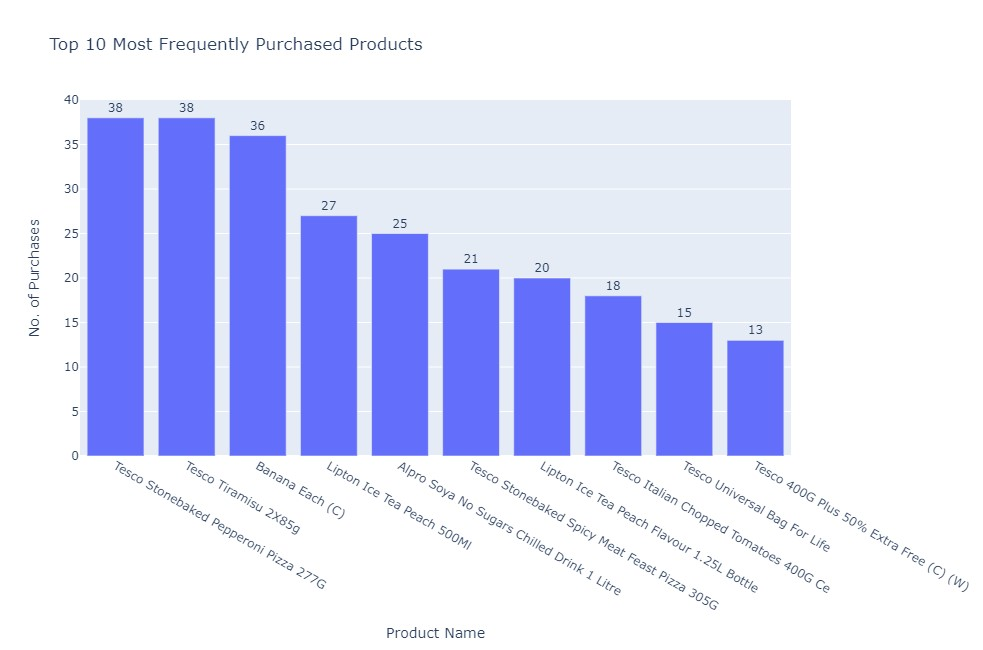

#### 4.3. Distribution of Purchases by Store

In [32]:
# Count the frequency of purchases by store and sort them in descending order
store_purchase_count = purchase_df['storeId'].value_counts().reset_index()
store_purchase_count.columns = ['Store ID', 'Number of Purchases']
print(store_purchase_count.head())

  Store ID  Number of Purchases
0     5989                  215
1     2239                   72
2     6005                    7
3     4911                    1
4     6063                    1


#### 4.4. Price Change Analysis for Tiramisu and Tomatoes

In [48]:
# Merge product_df with purchase_df to associate product prices with purchase timestamps
merged_df = pd.merge(product_df, purchase_df[['basket_id', 'timeStamp']], on='basket_id', how='left')

# Create a line plot
fig = px.line(
    merged_df[merged_df['name'] == "Tesco Tiramisu 2X85g"],
    x='timeStamp',  # Use the timestamp from purchase_df
    y='price',
    title=f"Price Change for Tesco Tiramisu 2X85g",
    labels={'timeStamp': 'Date of Purchase', 'price': 'Price (£)'}
)

# Customize the layout
fig.update_layout(
    autosize=False,  # Turn off automatic sizing
    width=600,       # Set the width of the figure
    height=400,      # Set the height of the figure
    margin=dict(t=50, b=50, l=50, r=20)  # Adjust the margins
)

# Show the plot
fig.show()

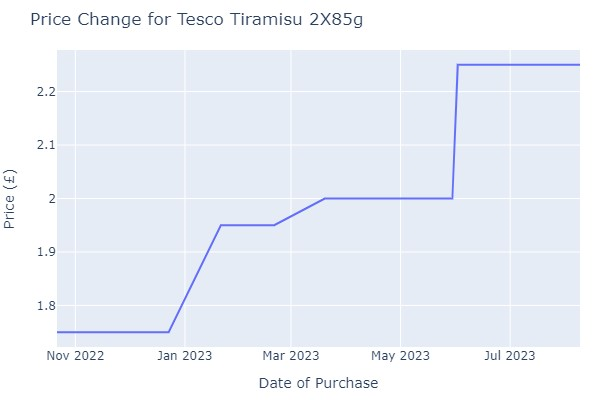

In [49]:
# Filter the merged dataframe for the specific product


# Create a line plot
fig = px.line(
    merged_df[merged_df['name'] == "Tesco Baby Plum Tomato 325G (C)"],
    x='timeStamp',  # Use the timestamp from purchase_df
    y='price',
    title=f"Price Change for Tesco Baby Plum Tomato 325G (C)",
    labels={'timeStamp': 'Date of Purchase', 'price': 'Price (£)'}
)

# Customize the layout
fig.update_layout(
    autosize=False,  # Turn off automatic sizing
    width=600,       # Set the width of the figure
    height=400,      # Set the height of the figure
    margin=dict(t=50, b=50, l=50, r=20)  # Adjust the margins
)

# Show the plot
fig.show()

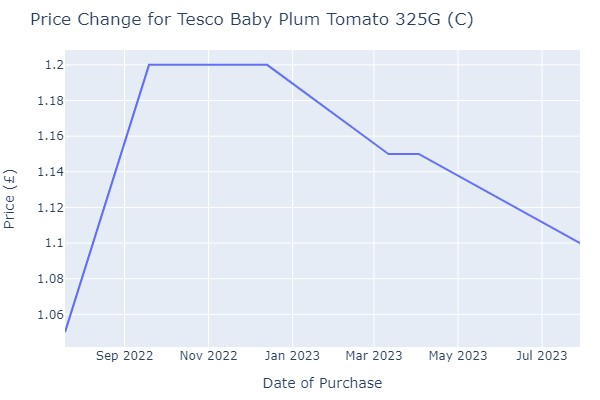

### 5. Exporting Cleaned Data to CSV Files

In [34]:
# Save the 'purchase_df' DataFrame to a CSV file named 'purchase_data.csv'
purchase_df.to_csv('data/out/purchase_data.csv', index=False)

# Save the 'product_df' DataFrame to a CSV file named 'product_data.csv'
product_df.to_csv('data/out/product_data.csv', index=False)

The two dataframes, **purchase_df** and **product_df** are now cleaned and prepared for further analysis. The CSV files generated below will serve as the input data for dashboarding tools like **Tableau** or **Power BI**. For a detailed walkthrough on how to perform this analysis and build dashboards, stay tuned for upcoming **Medium** articles.